# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [2]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

# Display basic info about the generated dataset
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nBasic statistics:")
print(df.describe())

File already exists at ../data/raw\outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [3]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [4]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


## TODO: Implement Outlier Functions (required)

In [5]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return pd.Series([False] * len(series), index=series.index)
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    if sigma == 0:
        return pd.Series([False] * len(series), index=series.index)
    z = (series - mu) / sigma
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [6]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Winsorize series by clipping extreme values to percentile bounds.
    Assumptions: extreme values are errors; preserving sample size is important.
    """
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [7]:
# Apply detection to daily_return column
target_col = 'daily_return' if 'daily_return' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)

print(f"Analyzing column: {target_col}")
print(f"Outliers detected - IQR: {df['outlier_iqr'].sum()} ({df['outlier_iqr'].mean():.2%})")
print(f"Outliers detected - Z-score: {df['outlier_z'].sum()} ({df['outlier_z'].mean():.2%})")

# Show outlier values
if df['outlier_iqr'].any():
    print(f"\nOutlier values (IQR):")
    outlier_data = df.loc[df['outlier_iqr']]
    if 'date' in df.columns:
        print(outlier_data[['date', target_col]].head(10))
    else:
        print(outlier_data[[target_col]].head(10))
else:
    print("No outliers detected with IQR method")

Analyzing column: x
Outliers detected - IQR: 0 (0.00%)
Outliers detected - Z-score: 0 (0.00%)
No outliers detected with IQR method


### Visual Checks (boxplot / histogram)

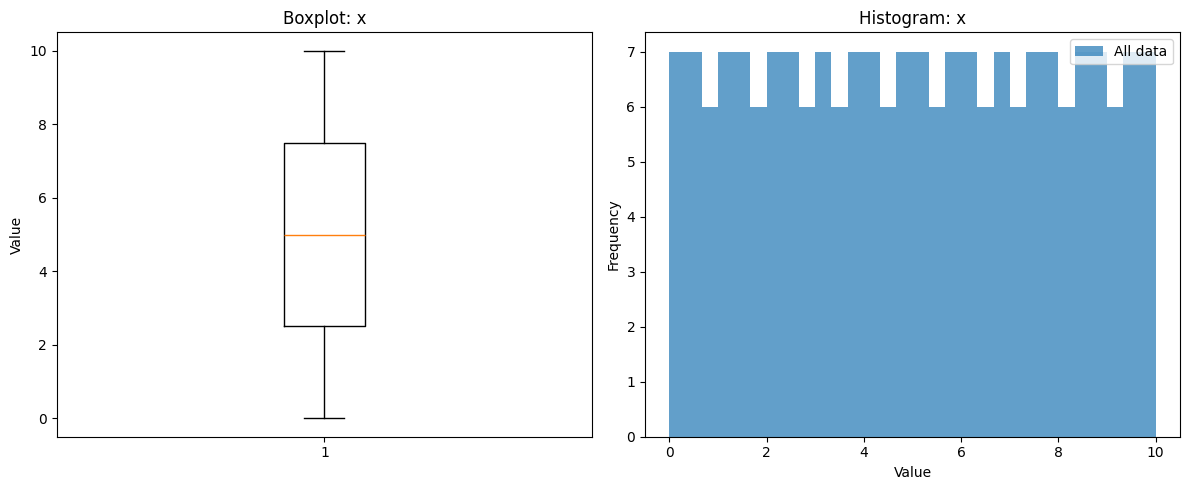

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
ax1.boxplot(df[target_col])
ax1.set_title(f'Boxplot: {target_col}')
ax1.set_ylabel('Value')

# Histogram with outliers highlighted
ax2.hist(df[target_col], bins=30, alpha=0.7, label='All data')
if df['outlier_iqr'].any():
    ax2.hist(df.loc[df['outlier_iqr'], target_col], bins=30, alpha=0.8, 
             color='red', label='IQR outliers')
ax2.set_title(f'Histogram: {target_col}')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [ ]:
# Summary stats comparison
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
w_series = winsorize_series(df[target_col])
summ_w = w_series.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat({
    'all_data': summ_all,
    'filtered_iqr': summ_filtered,
    'winsorized': summ_w
}, axis=1)

print("Summary Statistics Comparison:")
print(comp.round(6))

# Calculate percentage changes
print("\nPercentage change from original:")
for col in ['filtered_iqr', 'winsorized']:
    pct_change = ((comp[col] - comp['all_data']) / comp['all_data'] * 100).round(2)
    print(f"\n{col}:")
    for stat in pct_change.index:
        print(f"  {stat}: {pct_change[stat]:+.2f}%")

In [ ]:
# Time series regression analysis
if 'date' in df.columns:
    # Create numeric time variable
    df['time_numeric'] = (df['date'] - df['date'].min()).dt.days
    time_col = 'time_numeric'
elif 'x' in df.columns:
    time_col = 'x'
else:
    # Create a simple index-based time variable
    df['index_time'] = range(len(df))
    time_col = 'index_time'

# Prepare data for regression
X_all = df[[time_col]]
y_all = df[target_col]

mask_filtered = ~df['outlier_iqr']
X_filtered = df.loc[mask_filtered, [time_col]]
y_filtered = df.loc[mask_filtered, target_col]

X_winsorized = df[[time_col]]
y_winsorized = w_series

# Fit models
model_all = LinearRegression().fit(X_all, y_all)
model_flt = LinearRegression().fit(X_filtered, y_filtered)
model_win = LinearRegression().fit(X_winsorized, y_winsorized)

# Calculate metrics
results = pd.DataFrame({
    'slope': [model_all.coef_[0], model_flt.coef_[0], model_win.coef_[0]],
    'intercept': [model_all.intercept_, model_flt.intercept_, model_win.intercept_],
    'r2': [model_all.score(X_all, y_all), 
           model_flt.score(X_filtered, y_filtered),
           model_win.score(X_winsorized, y_winsorized)],
    'mae': [mean_absolute_error(y_all, model_all.predict(X_all)),
            mean_absolute_error(y_filtered, model_flt.predict(X_filtered)),
            mean_absolute_error(y_winsorized, model_win.predict(X_winsorized))]
}, index=['all_data', 'filtered_iqr', 'winsorized'])

print(f"\nRegression Analysis Results (using {time_col}):")
print(results.round(6))

### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

*Write your reflection here...*